In [1]:
import numpy
import corner
import emcee
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import scipy.optimize
import sys
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
import scipy.optimize as op
from astropy.constants import c
import functions_polarization_MCMC as mcmc
import function_plots as mcmc_plots
from importlib import reload
import time
import tqdm 

import scipy.stats
import math
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord

In [2]:
freqs = np.load('MKT_Freqs_mid.npy')

lamb = c.value/freqs

# Mock data maker:

In [3]:
#To make new data:
def models(x_local, p0, X0, RM, sigma, norm, a, curv):
    freq = (c.value/np.sqrt(x_local))*1.e-9

    mod_i = norm * freq**(a + curv*np.log10(freq))

    f = np.exp(-2*(sigma**2)*(x_local**2))
       
    mod_q = p0*f*mod_i *np.cos(2.* (X0 + RM*x_local))
    mod_u = p0*f*mod_i *np.sin(2.* (X0 + RM*x_local))
    
    mod_p = np.sqrt(mod_q**2 + mod_u**2) / mod_i
    
    return(mod_q, mod_u, mod_p, mod_i)

In [10]:
#To visualize:
def models(x_local, p0, X0, RM, sigma, norm, a, curv):
    freq = (c.value/np.sqrt(x_local))*1.e-9

    mod_i = norm * freq**(a + curv*np.log10(freq))

    f = np.exp(-2*(sigma**2)*(x_local**2))
       
    mod_q = p0*f*mod_i *np.cos(2.* (X0 + RM*x_local))
    mod_u = p0*f*mod_i *np.sin(2.* (X0 + RM*x_local))    

    return(mod_q, mod_u, mod_i)

x = np.linspace(0.02, 0.12, 1000)
x_sim = np.flip(lamb)**2
freqs_low = np.load('MKT_Freqs_low.npy')
freqs_high = np.load('MKT_Freqs_up.npy')
lamb_high = np.flip(c.value/freqs_low)
lamb_low = np.flip(c.value/freqs_high)

print(x_sim)
bin_edges_1 = np.append(lamb_low[:6], lamb_high[5])**2
bin_edges_2 = np.append(lamb_low[6:], lamb_high[-1])**2
bin_edges = np.append(bin_edges_1, bin_edges_2)

def simulator(x, p0, X0, RM, sigma, norm, spix, curv):
    model_q, model_u,model_i = models(x, p0, X0, RM, sigma, norm, spix, curv)

    model_i_sim_1,_,_ = scipy.stats.binned_statistic(x, model_i, statistic='mean', bins=bin_edges_1\
                                               , range=(np.min(bin_edges_1), np.max(bin_edges_1)))
    model_i_sim_2,_,_ = scipy.stats.binned_statistic(x, model_i, statistic='mean', bins=bin_edges_2\
                                               , range=(np.min(bin_edges_2), np.max(bin_edges_2)))
    model_i_sim = np.append(model_i_sim_1, model_i_sim_2)

    model_q_sim_1,_,_ = scipy.stats.binned_statistic(x, model_q, statistic='mean', bins=bin_edges_1\
                                               , range=(np.min(bin_edges_1), np.max(bin_edges_1)))
    model_q_sim_2,_,_ = scipy.stats.binned_statistic(x, model_q, statistic='mean', bins=bin_edges_2\
                                               , range=(np.min(bin_edges_2), np.max(bin_edges_2)))
    model_q_sim = np.append(model_q_sim_1, model_q_sim_2)

    model_u_sim_1,_,_ = scipy.stats.binned_statistic(x, model_u, statistic='mean', bins=bin_edges_1\
                                               , range=(np.min(bin_edges_1), np.max(bin_edges_1)))
    model_u_sim_2,_,_ = scipy.stats.binned_statistic(x, model_u, statistic='mean', bins=bin_edges_2\
                                               , range=(np.min(bin_edges_2), np.max(bin_edges_2)))
    model_u_sim = np.append(model_u_sim_1, model_u_sim_2)
    
    model_i_sim = model_i_sim*(1+np.random.normal(0, 0.05, size=12))
    model_q_sim = model_q_sim*(1+np.random.normal(0, 0.05, size=12))
    model_u_sim = model_u_sim*(1+np.random.normal(0, 0.05, size=12))
    
    model_i_sim_err, model_q_sim_err, model_u_sim_err = 0.05*model_i_sim, 0.05*model_q_sim, 0.05*model_u_sim
    
    return(model_i_sim, model_q_sim, model_u_sim, model_i_sim_err, model_q_sim_err, model_u_sim_err)

[0.03276538 0.0353758  0.03890331 0.04286202 0.04711316 0.05179874
 0.06860066 0.07526213 0.08254497 0.09048136 0.09909591 0.10900194]


Text(0.5, 113.99999999999989, 'curv')

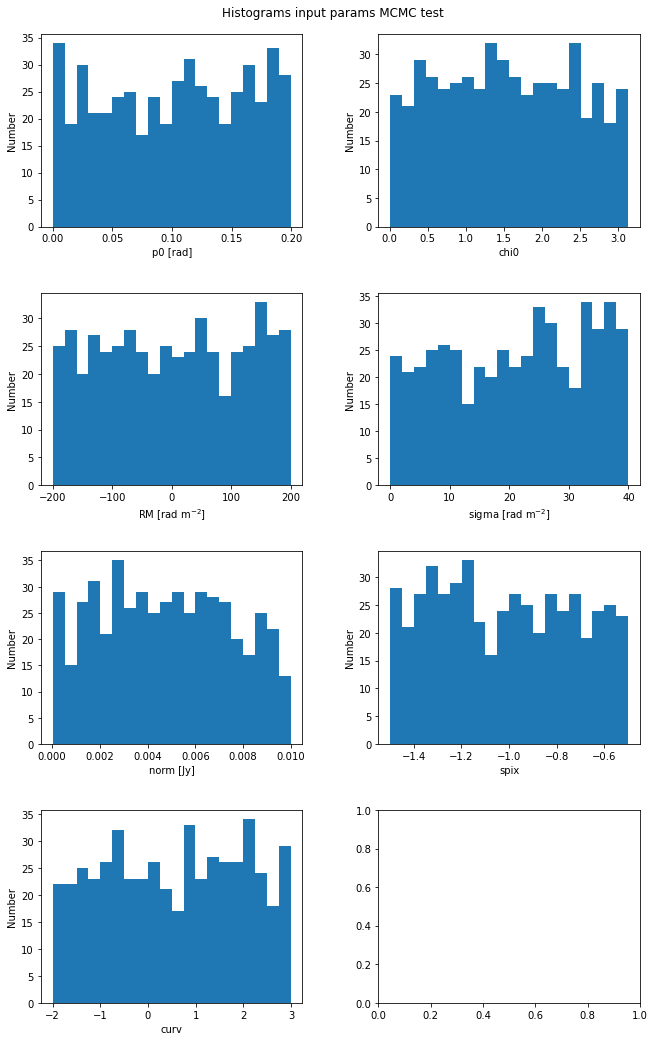

In [5]:
#Based on found distributions:
num_sims = 500
np.random.seed(1)
mock_p0 = 0.2*np.random.random(size=num_sims) #random from 0 to 0.2
mock_X0 = np.pi*np.random.random(size=num_sims) #random from 0 to pi
mock_RM = 400*np.random.random(size=num_sims)-200 #random from -200 to 200
mock_sigma = 40*np.random.random(size=num_sims) #random from 0 to 40
mock_norm = 0.01*np.random.random(size=num_sims) #random from 0 to 0.02
mock_spix = 1*np.random.random(size=num_sims)-1.5 #random from -1.5 to -0.5
mock_curv = 5*np.random.random(size=num_sims)-2 #random from -4 to 6

phi_mock = np.round(mock_RM/10)*10

fig, axs = plt.subplots(4, 2)
fig.set_size_inches(10, 15)
fig.tight_layout(pad=4.5)

fig.suptitle('Histograms input params MCMC test')

axs[0,0].hist(mock_p0, bins=20)
axs[0,0].set_ylabel('Number')
axs[0,0].set_xlabel('p0 [rad]')

axs[0,1].hist(mock_X0, bins=20)
axs[0,1].set_ylabel('Number')
axs[0,1].set_xlabel('chi0')

axs[1,0].hist(mock_RM, bins=20)
axs[1,0].set_ylabel('Number')
axs[1,0].set_xlabel(r'RM [rad m$^{-2}$]')

axs[1,1].hist(mock_sigma, bins=20)#, bins=np.linspace(0,200,20))
axs[1,1].set_ylabel('Number')
axs[1,1].set_xlabel(r'sigma [rad m$^{-2}$]')

axs[2,0].hist(mock_norm, bins=20)
axs[2,0].set_ylabel('Number')
axs[2,0].set_xlabel('norm [Jy]')

axs[2,1].hist(mock_spix, bins=20)
axs[2,1].set_ylabel('Number')
axs[2,1].set_xlabel('spix')

axs[3,0].hist(mock_curv, bins=20)
axs[3,0].set_ylabel('Number')
axs[3,0].set_xlabel(r'curv')

In [6]:
mock_i, mock_q, mock_u = np.zeros((12,num_sims)), np.zeros((12,num_sims)), np.zeros((12,num_sims))
mock_i_err, mock_q_err, mock_u_err = np.zeros((12,num_sims)), np.zeros((12,num_sims)), np.zeros((12,num_sims))

for n in range(num_sims):
    mock_i[:,n], mock_q[:,n], mock_u[:,n], mock_i_err[:,n], mock_q_err[:,n], mock_u_err[:,n] = \
    simulator(x, mock_p0[n], mock_X0[n], mock_RM[n], mock_sigma[n], mock_norm[n], mock_spix[n], mock_curv[n])
    
mock_angles = 0.5*np.arctan2(mock_u, mock_q)
mock_angles_err = np.sqrt((mock_q*mock_u_err)**2 + (mock_u*mock_q_err)**2)/(2*(mock_u**2 + mock_q**2))
mock_linpol = np.sqrt(mock_u**2 + mock_q**2)
mock_linpol_err = (mock_u*mock_u_err + mock_q*mock_q_err)/mock_linpol
mock_p = mock_linpol/mock_i
mock_p_err = mock_p*np.sqrt((0*mock_linpol_err/mock_linpol)**2 + (mock_i_err/mock_i)**2)

print(mock_i)

[[0.00548658 0.00449894 0.00365479 ... 0.0042231  0.00139647 0.00236721]
 [0.00559052 0.00482518 0.00381782 ... 0.00423529 0.00162619 0.00237132]
 [0.00515223 0.00484781 0.00387555 ... 0.0044518  0.00160756 0.00252644]
 ...
 [0.00569226 0.00950392 0.00593132 ... 0.00555684 0.00373868 0.00363025]
 [0.00569197 0.0083122  0.00631489 ... 0.0063359  0.0034658  0.00369955]
 [0.00576087 0.00943672 0.00592243 ... 0.00654411 0.00393277 0.00369893]]


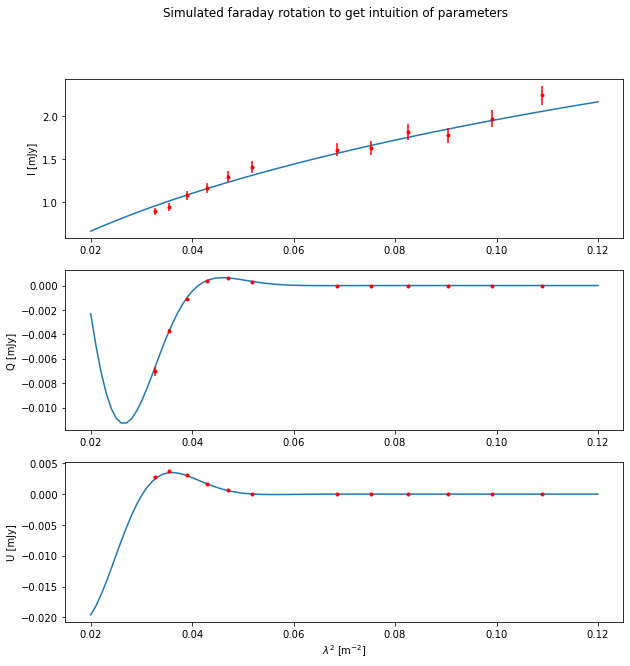

0.06911214540860955 0.5816042991581393 -71.2684800119022 32.26987243099454 0.0018449560449017766 -1.1653194671154068


In [24]:
inspect_num = 7

model_q, model_u, model_i = models(np.linspace(0.02,0.12,100), mock_p0[inspect_num], mock_X0[inspect_num], mock_RM[inspect_num]\
        , mock_sigma[inspect_num], mock_norm[inspect_num], mock_spix[inspect_num], mock_curv[inspect_num])

fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Simulated faraday rotation to get intuition of parameters')
axs[0].plot(np.linspace(0.02,0.12,100), 1e3*model_i)
axs[0].errorbar(x_sim, 1e3*mock_i[:,inspect_num], yerr=1e3*mock_i_err[:,inspect_num], color='red', fmt='.')
axs[0].set_ylabel('I [mJy]')
                  
axs[1].plot(np.linspace(0.02,0.12,100), 1e3*model_q)
axs[1].errorbar(x_sim, 1e3*mock_q[:,inspect_num], yerr=1e3*mock_q_err[:,inspect_num], color='red', fmt='.')
axs[1].set_ylabel('Q [mJy]')

axs[2].plot(np.linspace(0.02,0.12,100), 1e3*model_u)
axs[2].errorbar(x_sim, 1e3*mock_u[:,inspect_num], yerr=1e3*mock_u_err[:,inspect_num], color='red', fmt='.')
axs[2].set_ylabel('U [mJy]')
axs[2].set_xlabel('$\lambda^2$ [m$^{-2}$]')

plt.show()

print(mock_p0[inspect_num], mock_X0[inspect_num], mock_RM[inspect_num]\
        , mock_sigma[inspect_num], mock_norm[inspect_num], mock_spix[inspect_num])

In [27]:
savedir =r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/Photometry_BDSF/'

np.save(savedir+'I_mock.npy', mock_i)
np.save(savedir+'Q_mock.npy', mock_q)
np.save(savedir+'U_mock.npy', mock_u)
np.save(savedir+'unc_I_mock.npy', mock_i_err)
np.save(savedir+'unc_Q_mock.npy', mock_q_err)
np.save(savedir+'unc_U_mock.npy', mock_u_err)
np.save(savedir+'phi_mock.npy', phi_mock)

# Testing the MCMC:

In [28]:
redchisq_I_list = np.zeros(num_sims)
redchisq_QU_list = np.zeros(num_sims)

norm_list = np.zeros((num_sims,3))
spix_list = np.zeros((num_sims,3))
curv_list = np.zeros((num_sims,3))
p0_list = np.zeros((num_sims,3))
chi0_list = np.zeros((num_sims,3))
RM_list = np.zeros((num_sims,3))
sigma_list = np.zeros((num_sims,3))

In [ ]:
reload(mcmc)
reload(mcmc_plots)

for n in tqdm.tqdm(range(num_sims)):
    fit_dataI, fit_data, x, y = mcmc.polarization_fitting(lamb**2, mock_i[:,n], mock_i_err[:,n]\
                        , mock_q[:,n], mock_q_err[:,n], mock_u[:,n], mock_u_err[:,n]\
                        , phi_mock[n], 0, 0, cornerplot=False,curvature=True\
                        , sourcenum=0)
    redchisq = mcmc_plots.models('ExtDepol', lamb**2, fit_dataI[0][1], fit_dataI[1][1], fit_dataI[2][1]\
                ,fit_data[0][1], fit_data[1][1], fit_data[2][1], fit_data[3][1], mock_i[:,n], mock_i_err[:,n]\
                        , mock_q[:,n], mock_q_err[:,n], mock_u[:,n], mock_u_err[:,n])

    redchisq_I_list[n] = redchisq[3]
    redchisq_QU_list[n] = redchisq[4]

    norm_list[n] = fit_dataI[0][1:]
    spix_list[n] = fit_dataI[1][1:]
    curv_list[n] = fit_dataI[2][1:]
    
    p0_list[n] = fit_data[0][1:]
    chi0_list[n] = fit_data[1][1:]
    RM_list[n] = fit_data[2][1:]
    sigma_list[n] = fit_data[3][1:]

  2%|▏         | 8/500 [01:26<1:23:46, 10.22s/it]

In [ ]:
def uncertainty(array):
    return np.mean(np.abs(array[:,1:]), axis=1)

norm_unc_list = uncertainty(norm_list)
spix_unc_list = uncertainty(spix_list)
curv_unc_list = uncertainty(curv_list)
p0_unc_list = uncertainty(p0_list)
chi0_unc_list = uncertainty(chi0_list)
RM_unc_list = uncertainty(RM_list)
sigma_unc_list = uncertainty(sigma_list)

mask_inspec = np.argwhere((sigma_list[:,0]<1e10))#&(sigma_unc_list/sigma_list[:,0]< 1))#&(redchisq_QU_list < 40)
print(len(mask_inspec))

In [ ]:

fig, axs = plt.subplots(4, 2)
fig.set_size_inches(10, 15)
fig.tight_layout(pad=4.5)

fig.suptitle('Histograms output params MCMC test')

axs[0,0].hist(mock_p0[mask_inspec], bins=20)
axs[0,0].set_ylabel('Number')
axs[0,0].set_xlabel('p0 [rad]')
axs[0,0].set_xlim(0, 0.1)
axs[0,0].set_title('Input p0')

axs[0,1].hist(p0_list[:,0][mask_inspec], bins=200)
axs[0,1].set_ylabel('Number')
axs[0,1].set_xlabel('p0 [rad]')
axs[0,1].set_xlim(0, 0.1)
axs[0,1].set_title('Output p0')

axs[1,0].hist(mock_X0[mask_inspec], bins=20)
axs[1,0].set_ylabel('Number')
axs[1,0].set_xlabel('chi0')
axs[1,0].set_title('Input chi0')

axs[1,1].hist(chi0_list[:,0][mask_inspec], bins=20)
axs[1,1].set_ylabel('Number')
axs[1,1].set_xlabel('chi0')
axs[1,1].set_title('Output chi0')

axs[2,0].hist(mock_RM[mask_inspec], bins=20)
axs[2,0].set_ylabel('Number')
axs[2,0].set_xlabel(r'RM [rad m$^{-2}$]')
axs[2,0].set_title('Input RM')

axs[2,1].hist(RM_list[:,0][mask_inspec], bins=200)
axs[2,1].set_ylabel('Number')
axs[2,1].set_xlabel(r'RM [rad m$^{-2}$]')
axs[2,1].set_xlim(-500,500)
axs[2,1].set_title('Output RM')

axs[3,0].hist(mock_sigma[mask_inspec], bins=20)
axs[3,0].set_ylabel('Number')
axs[3,0].set_xlabel(r'sigma [rad m$^{-2}$]')
axs[3,0].set_title('Input sigma')

axs[3,1].hist(np.sqrt(sigma_list[:,0][mask_inspec]), bins=100)
axs[3,1].set_ylabel('Number')
axs[3,1].set_xlabel(r'sigma [rad m$^{-2}$]')
axs[3,1].set_title('Output sigma')
axs[3,1].set_xlim(0, 100)

In [ ]:
plt.errorbar(mock_RM[mask_inspec], RM_list[:,0][mask_inspec], fmt='.')
plt.plot([-200,200],[-200,200], color='black')
plt.xlim(-250,250)
plt.ylim(-250,250)
plt.xlabel('Input mock RM [rad m$^{-2}$]')
plt.ylabel('Output MCMC RM [rad m$^{-2}$]')
plt.show()

plt.errorbar(mock_sigma[mask_inspec], np.sqrt(sigma_list[:,0][mask_inspec]), fmt='.')
plt.plot([0,40],[0,40], color='black')
#plt.yscale('log')
plt.xlim(-10,50)
plt.ylim(-10,50)
plt.xlabel('Input mock sigma [rad m$^{-2}$]')
plt.ylabel('Output MCMC sigma [rad m$^{-2}$]')
plt.show()

plt.errorbar(mock_X0[mask_inspec], chi0_list[:,0][mask_inspec], fmt='.')
plt.plot([0,np.pi],[0,np.pi], color='black')
plt.xlabel('Input mock chi0 [rad]')
plt.ylabel('Output MCMC chi0 [rad]')
plt.show()


plt.errorbar(mock_p0[mask_inspec], p0_list[:,0][mask_inspec], fmt='.')
plt.plot([0,0.2],[0,0.2], color='black')
plt.xlim(-0.01,0.21)
plt.ylim(-0.01,0.21)
plt.xlabel('Input mock p0')
plt.ylabel('Output MCMC p0')
plt.show()

In [ ]:
print(np.argwhere((p0_list[:,0]<1e-10))[:,0])

number = 7

print(number)
print('Chi0, p0, RM, sigma, redchisqw')
print(mock_X0[number], mock_p0[number], mock_RM[number], mock_sigma[number])
print(chi0_list[number,0], p0_list[number,0], RM_list[number,0], sigma_list[number,0], redchisq_QU_list[number])
print(mock_i[np.isnan(mock_q_err)])

mcmc_plots.plots('ExtDepol', 'depolfit_test', lamb**2, norm_list[number,0], spix_list[number,0], curv_list[number,0]\
            , p0_list[number,0], chi0_list[number,0], RM_list[number,0], np.sqrt(sigma_list[number,0]), mock_i[:,number]\
            , mock_i_err[:,number], mock_q[:,number], mock_q_err[:,number], mock_u[:,number], mock_u_err[:,number]\
            , mock_angles[:,number], mock_angles_err[:,number], mock_p[:,number]\
            , mock_p_err[:,number], xlim=[0.02, 0.12], imgformat="pdf",saveplot=False)

# Testing the MCMC on Eriks frequencies:

In [332]:
def simulator_erik(x, p0, X0, RM, sigma, norm, spix, curv):
    model_q, model_u,model_i = models(x, p0, X0, RM, sigma, norm, spix, curv)

    model_i = model_i*(1+np.random.normal(0, 0.1, size=90))
    model_q = model_q*(1+np.random.normal(0, 0.1, size=90))
    model_u = model_u*(1+np.random.normal(0, 0.1, size=90))
    
    model_i_sim_err, model_q_sim_err, model_u_sim_err = 0.1*model_i, 0.1*model_q, 0.1*model_u
    
    return(model_i, model_q, model_u, model_i_sim_err, model_q_sim_err, model_u_sim_err)

In [333]:
x_erik = np.loadtxt('/net/vdesk/data2/GoesaertW/VLA_Data/lambda_squared.txt')[:,0]

mock_i_erik, mock_q_erik, mock_u_erik = np.zeros((90,num_sims)), np.zeros((90,num_sims)), np.zeros((90,num_sims))
mock_i_err_erik, mock_q_err_erik, mock_u_err_erik = np.zeros((90,num_sims)), np.zeros((90,num_sims)), np.zeros((90,num_sims))

for n in range(num_sims):
    mock_i_erik[:,n], mock_q_erik[:,n], mock_u_erik[:,n], mock_i_err_erik[:,n], mock_q_err_erik[:,n]\
    , mock_u_err_erik[:,n] = simulator_erik(x_erik, mock_p0[n], mock_X0[n], mock_RM[n], mock_sigma[n]\
    , mock_norm[n], mock_spix[n], mock_curv[n])

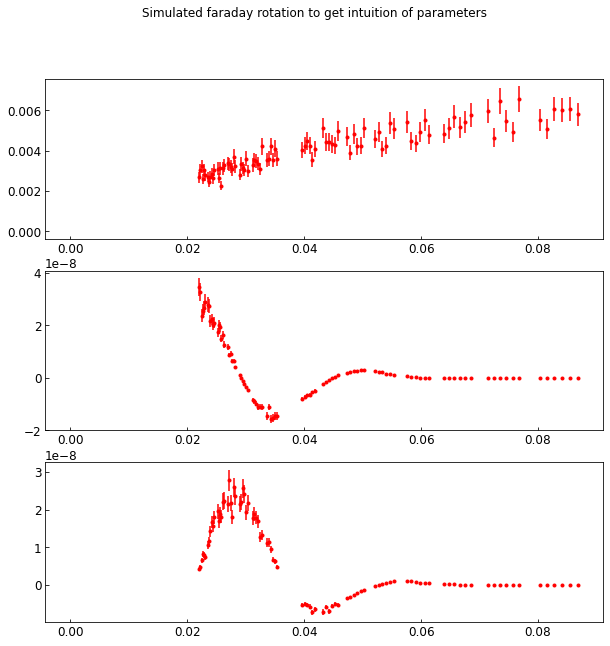

In [334]:
inspect_num = 2
model_q, model_u, model_i = models(x, mock_p0[inspect_num], mock_X0[inspect_num], mock_RM[inspect_num]\
        , mock_sigma[inspect_num], mock_norm[inspect_num], mock_spix[inspect_num], mock_curv[inspect_num])

fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Simulated faraday rotation to get intuition of parameters')
axs[0].plot(x, model_i)
axs[0].errorbar(x_erik, mock_i_erik[:,inspect_num], yerr=mock_i_err_erik[:,inspect_num], color='red', fmt='.')

axs[1].plot(x, model_q)
axs[1].errorbar(x_erik, mock_q_erik[:,inspect_num], yerr=mock_q_err_erik[:,inspect_num], color='red', fmt='.')

axs[2].plot(x, model_u)
axs[2].errorbar(x_erik, mock_u_erik[:,inspect_num], yerr=mock_u_err_erik[:,inspect_num], color='red', fmt='.')

plt.show()

In [335]:
redchisq_I_list_erik = np.zeros(num_sims)
redchisq_QU_list_erik = np.zeros(num_sims)

norm_list_erik = np.zeros((num_sims,3))
spix_list_erik = np.zeros((num_sims,3))
curv_list_erik = np.zeros((num_sims,3))
p0_list_erik = np.zeros((num_sims,3))
chi0_list_erik = np.zeros((num_sims,3))
RM_list_erik = np.zeros((num_sims,3))
sigma_list_erik = np.zeros((num_sims,3))

In [336]:
reload(mcmc)
reload(mcmc_plots)

for n in tqdm.tqdm(range(num_sims)):
    fit_dataI, fit_data, x, y = mcmc.polarization_fitting(x_erik, mock_i_erik[:,n], mock_i_err_erik[:,n]\
                        , mock_q_erik[:,n], mock_q_err_erik[:,n], mock_u_erik[:,n], mock_u_err_erik[:,n]\
                        , phi_mock[n], 0, 0, cornerplot=False,curvature=True\
                        , sourcenum=0)
    redchisq = mcmc_plots.models('ExtDepol', x_erik, fit_dataI[0][1], fit_dataI[1][1], fit_dataI[2][1]\
                ,fit_data[0][1], fit_data[1][1], fit_data[2][1], fit_data[3][1], mock_i_erik[:,n], mock_i_err_erik[:,n]\
                        , mock_q_erik[:,n], mock_q_err_erik[:,n], mock_u_erik[:,n], mock_u_err_erik[:,n])

    redchisq_I_list_erik[n] = redchisq[3]
    redchisq_QU_list_erik[n] = redchisq[4]

    norm_list_erik[n] = fit_dataI[0][1:]
    spix_list_erik[n] = fit_dataI[1][1:]
    curv_list_erik[n] = fit_dataI[2][1:]
    
    p0_list_erik[n] = fit_data[0][1:]
    chi0_list_erik[n] = fit_data[1][1:]
    RM_list_erik[n] = fit_data[2][1:]
    sigma_list_erik[n] = fit_data[3][1:]

 95%|█████████▌| 477/500 [1:58:07<05:53, 15.37s/it]  /usr/lib64/python3.10/site-packages/scipy/optimize/_minpack_py.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
100%|██████████| 500/500 [2:03:56<00:00, 14.87s/it]


In [337]:
sigma_unc_list_erik = uncertainty(sigma_list_erik)

mask_inspec = np.argwhere((sigma_unc_list_erik/sigma_list_erik[:,0]< 2))#(redchisq_QU_list_erik<40)&
print(len(mask_inspec))

471


(0.0, 0.08)

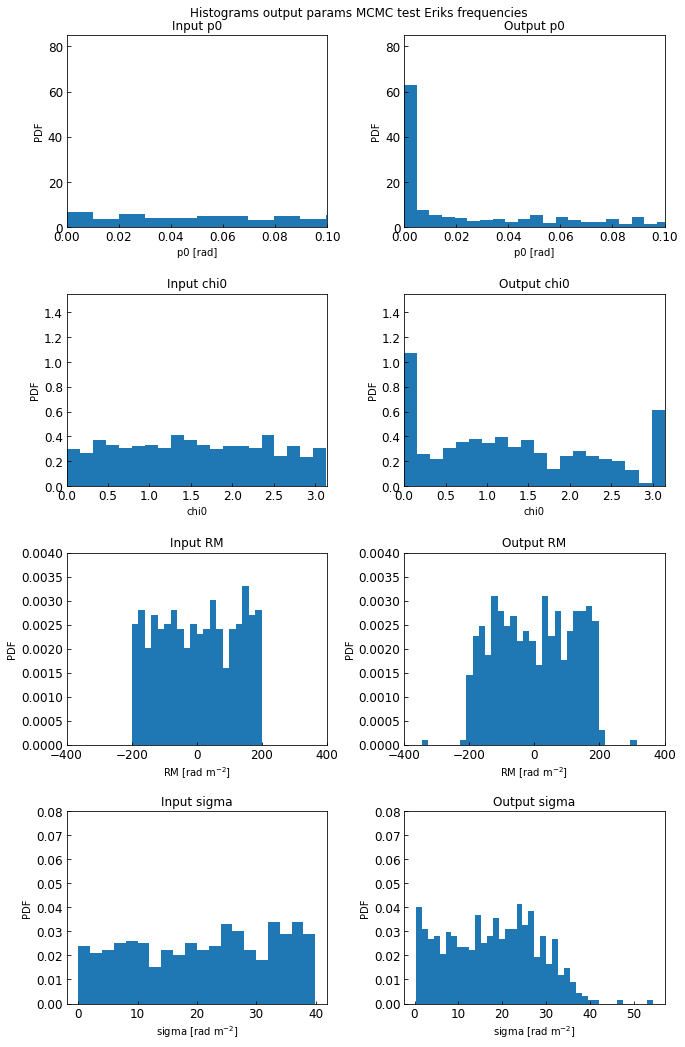

In [338]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(10, 15)
fig.tight_layout(pad=4.5)

fig.suptitle('Histograms output params MCMC test Eriks frequencies')

axs[0,0].hist(mock_p0, bins=20, density=True)
axs[0,0].set_ylabel('PDF')
axs[0,0].set_xlabel('p0 [rad]')
axs[0,0].set_xlim(0, 0.1)
axs[0,0].set_ylim(0, 85)
axs[0,0].set_title('Input p0')

axs[0,1].hist(p0_list_erik[:,0], bins=200, density=True)
axs[0,1].set_ylabel('PDF')
axs[0,1].set_xlabel('p0 [rad]')
axs[0,1].set_xlim(0, 0.1)
axs[0,1].set_ylim(0, 85)
axs[0,1].set_title('Output p0')

axs[1,0].hist(mock_X0, bins=20, density=True)
axs[1,0].set_ylabel('PDF')
axs[1,0].set_xlabel('chi0')
axs[1,0].set_xlim(0, np.pi)
axs[1,0].set_ylim(0, 1.55)
axs[1,0].set_title('Input chi0')

axs[1,1].hist(chi0_list_erik[:,0], bins=20, density=True)
axs[1,1].set_ylabel('PDF')
axs[1,1].set_xlabel('chi0')
axs[1,1].set_xlim(0, np.pi)
axs[1,1].set_ylim(0, 1.55)
axs[1,1].set_title('Output chi0')

axs[2,0].hist(mock_RM, bins=20, density=True)
axs[2,0].set_ylabel('PDF')
axs[2,0].set_xlabel(r'RM [rad m$^{-2}$]')
axs[2,0].set_xlim(-400, 400)
axs[2,0].set_ylim(0,0.004)
axs[2,0].set_title('Input RM')

axs[2,1].hist(RM_list_erik[:,0], bins=40, density=True)
axs[2,1].set_ylabel('PDF')
axs[2,1].set_xlabel(r'RM [rad m$^{-2}$]')
axs[2,1].set_xlim(-400,400)
axs[2,1].set_ylim(0,0.004)
axs[2,1].set_title('Output RM')

axs[3,0].hist(mock_sigma, bins=20, density=True)
axs[3,0].set_ylabel('PDF')
axs[3,0].set_xlabel(r'sigma [rad m$^{-2}$]')
axs[3,0].set_ylim(0,0.08)
#axs[3,0].set_xlim(0, 40)
axs[3,0].set_title('Input sigma')

axs[3,1].hist(np.sqrt(sigma_list_erik[:,0]), bins=40, density=True)
axs[3,1].set_ylabel('PDF')
axs[3,1].set_xlabel(r'sigma [rad m$^{-2}$]')
axs[3,1].set_title('Output sigma')
axs[3,1].set_ylim(0,0.08)

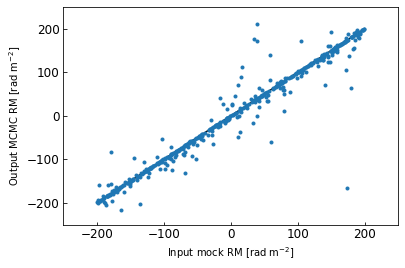

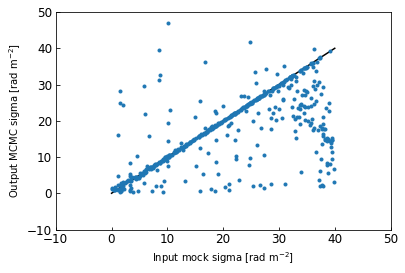

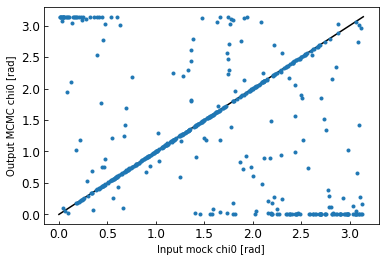

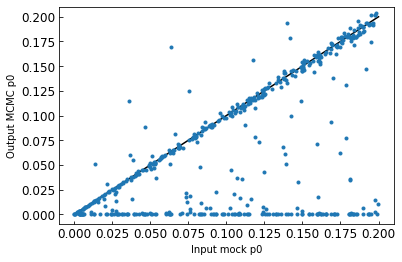

In [339]:
plt.errorbar(mock_RM, RM_list_erik[:,0], fmt='.')
plt.plot([-200,200],[-200,200], color='black')
plt.xlim(-250,250)
plt.ylim(-250,250)
plt.xlabel('Input mock RM [rad m$^{-2}$]')
plt.ylabel('Output MCMC RM [rad m$^{-2}$]')
plt.show()

plt.errorbar(mock_sigma, np.sqrt(sigma_list_erik[:,0]), fmt='.')
plt.plot([0,40],[0,40], color='black')
#plt.yscale('log')
plt.xlim(-10,50)
plt.ylim(-10,50)
plt.xlabel('Input mock sigma [rad m$^{-2}$]')
plt.ylabel('Output MCMC sigma [rad m$^{-2}$]')
plt.show()

plt.errorbar(mock_X0, chi0_list_erik[:,0], fmt='.')
plt.plot([0,np.pi],[0,np.pi], color='black')
plt.xlabel('Input mock chi0 [rad]')
plt.ylabel('Output MCMC chi0 [rad]')
plt.show()


plt.errorbar(mock_p0, p0_list_erik[:,0], fmt='.')
plt.plot([0,0.2],[0,0.2], color='black')
plt.xlim(-0.01,0.21)
plt.ylim(-0.01,0.21)
plt.xlabel('Input mock p0')
plt.ylabel('Output MCMC p0')
plt.show()